In [1]:
working_directory = '/mnt/DataRAID/melismail/PDAC'
import os
os.chdir(working_directory)
from pickle_utils import write_pickle, read_pickle

import sys, cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir 
from os.path import isfile, join
from tifffile import imread, imsave
from glob import glob

np.random.seed(42)

In [2]:
base_path = '/mnt/DataRAID/melismail/PDAC/data'
masks_path ='Preprocessing_images'
filtered_path = 'filtered'
dim = 512 #512
dim_path = f"{dim}x{dim}"
preprocessing_path ='Preprocessing_celltypes_annotation'
out_path = "Preprocessing_mask_annotation"
model_path = 'InceptionV3' #VGG-16 #ResNet50

In [3]:
filtered_masks_dict = read_pickle(path=os.path.join(base_path, masks_path, filtered_path, dim_path, f"{filtered_path}_{dim_path}_mask_dict.pkl"))
df_combined = read_pickle(path=os.path.join(base_path, preprocessing_path, model_path, f"{model_path}_celltypes_lbl_df.pkl"))

In [4]:
tumor_mask = {key for (key,value) in filtered_masks_dict.items() if len(np.where(value == 1)[0]) > 0}

In [5]:
df_masks = pd.DataFrame(tumor_mask)

In [6]:
df_masks.columns = ['Pseudonym', 'tile_id']

In [7]:
df_masks.head()

,Pseudonym,tile_id
0,IAA2LDX17,"(10, 0)"
1,IAA2LDX17,"(3, 24)"
2,IEV81RDT6,"(22, 29)"
3,IEV81RDT6,"(4, 25)"
4,IL771K246,"(16, 22)"


In [8]:
df_masks['lbl_mask'] = "cancer"

In [9]:
df_masks.head()

,Pseudonym,tile_id,lbl_mask
0,IAA2LDX17,"(10, 0)",cancer
1,IAA2LDX17,"(3, 24)",cancer
2,IEV81RDT6,"(22, 29)",cancer
3,IEV81RDT6,"(4, 25)",cancer
4,IL771K246,"(16, 22)",cancer


In [10]:
df_combined.head()

,tile_id,Pseudonym,Acinar cells,Alpha cells,B cells,Basal,Beta cells,Classical_CEACAM,Classical_KRT7,Classical_REG4,...,Macrophages_M2,NK cells,Schwann cells,T cells,iCAF,myCAF_ACTA2,myCAF_POSTN,most_prevalent_cancer,Features,lbl
0,"(0, 10)",IAA2LDX17,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Classical_KRT7,"[0.11127892, 0.082550116, 0.013145252, 0.14383...",cancer
1,"(0, 11)",IAA2LDX17,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Classical_CEACAM,"[0.088218965, 0.045640353, 0.0048801894, 0.144...",cancer
2,"(0, 12)",IAA2LDX17,1.0,0.0,4.0,6.0,1.0,30.0,1.0,0.0,...,1.0,2.0,2.0,1.0,1.0,2.0,0.0,Classical_CEACAM,"[0.14599374, 0.060965236, 0.00016441147, 0.136...",cancer
3,"(0, 13)",IAA2LDX17,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Classical_CEACAM,"[0.16967882, 0.14898822, 0.01608835, 0.1665820...",cancer
4,"(1, 2)",1C73PUTH4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Basal,"[0.036901504, 0.026912397, 0.0048136557, 0.123...",cancer


In [11]:
df_combined_tumor = df_masks.merge(df_combined, on=["Pseudonym", "tile_id"], how="right").fillna("non-cancer")
print(df_combined_tumor.head())

   Pseudonym  tile_id    lbl_mask  Acinar cells  Alpha cells  B cells  Basal  \
0  IAA2LDX17  (0, 10)  non-cancer           0.0          0.0      0.0    0.0   
1  IAA2LDX17  (0, 11)  non-cancer           0.0          0.0      0.0    0.0   
2  IAA2LDX17  (0, 12)  non-cancer           1.0          0.0      4.0    6.0   
3  IAA2LDX17  (0, 13)  non-cancer           0.0          0.0      0.0    0.0   
4  1C73PUTH4   (1, 2)  non-cancer           0.0          0.0      0.0    1.0   

   Beta cells  Classical_CEACAM  Classical_KRT7  ...  Macrophages_M2  \
0         0.0               1.0             2.0  ...             0.0   
1         0.0               3.0             0.0  ...             0.0   
2         1.0              30.0             1.0  ...             1.0   
3         0.0               1.0             0.0  ...             0.0   
4         0.0               0.0             0.0  ...             0.0   

   NK cells  Schwann cells  T cells  iCAF  myCAF_ACTA2  myCAF_POSTN  \
0       0.0    

non-cancer    1526
cancer         803
Name: lbl_mask, dtype: int64
non-cancer    1849
cancer         480
Name: lbl, dtype: int64


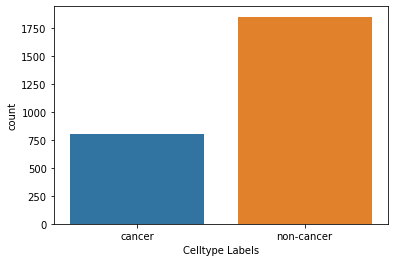

In [12]:
sns.countplot(data=df_combined_tumor, x="lbl_mask", order = sorted(df_combined_tumor["lbl_mask"].unique()))
plt.xlabel('Mask Labels')
plt.savefig(f"{model_path}_lbl_mask_classdistribution_count.png", dpi = 400)
print(df_combined_tumor["lbl_mask"].value_counts())
sns.countplot(data=df_combined_tumor, x="lbl", order = sorted(df_combined_tumor["lbl"].unique()))
plt.xlabel('Celltype Labels')
plt.savefig(f"{model_path}_lbl_classdistribution_count.png", dpi = 400)
print(df_combined_tumor["lbl"].value_counts())

In [13]:
df_combined_tumor["same"] = df_combined_tumor["lbl_mask"] == df_combined_tumor["lbl"]
df_combined_tumor[~df_combined_tumor["same"]].shape[0]

929

In [14]:
#write_pickle(path=os.path.join(base_path, out_path, model_path, f"{model_path}_celltypes_lbl_df.pkl"), obj=df_combined_tumor)